## Data Collection and Feature Engineering steps

In [1]:
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer

def load_data(data_url):
    return pd.read_csv(data_url, sep='\t')

# Preprocess the data: rename columns and remove multiple emotions
def preprocess_data(data):
    header = ["comment", "emotion", "id"]
    data.columns = header
    data = data[['comment', 'emotion']]
    data = data[data['emotion'].apply(lambda x: len(x.split(',')) == 1)]
    data['emotion'] = data['emotion'].apply(lambda x: ''.join(filter(str.isdigit, str(x)))).astype(int)
    return data

# Sample a fraction of the data for each emotion category
def sample_data(data, fraction=1.0):
    sampled = data.groupby('emotion').sample(frac=fraction, replace=False)
    return sampled.reset_index(drop=True)

# Tokenize the comments using the BERT tokenizer
def tokenize_data(comments):
    # Tokenize using the BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    return tokenizer(comments, padding=True, truncation=True, return_tensors='pt')

# URLs for train
train_data_url = 'https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/train.tsv'

# Process train data
train_data = load_data(train_data_url)
train_data = preprocess_data(train_data)
sampled_train_data = sample_data(train_data, 0.1)

# Tokenize the comments
train_tokenized_comments = tokenize_data(sampled_train_data['comment'].to_list())

# Prepare training data
X_train = train_tokenized_comments['input_ids']
attention_masks_train = train_tokenized_comments['attention_mask']
y_train = sampled_train_data['emotion'].values

# Map the new labels to their original emotion names
emotions_dict = {
    0: "admiration", 1: "amusement", 2: "anger", 3: "annoyance", 4: "approval",
    5: "caring", 6: "confusion", 7: "curiosity", 8: "desire", 9: "disappointment",
    10: "disapproval", 11: "disgust", 12: "embarrassment", 13: "excitement", 14: "fear",
    15: "gratitude", 16: "grief", 17: "joy", 18: "love", 19: "nervousness",
    20: "optimism", 21: "pride", 22: "realization", 23: "relief", 24: "remorse",
    25: "sadness", 26: "surprise", 27: "neutral"
}

print()
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("y_train unique:", np.unique(y_train))

/var/folders/xd/gw_pmm5d23s8dm3h09tn28x00000gn/T/ipykernel_26151/935588576.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby('emotion', group_keys=False).apply(lambda x: x.sample(frac=fraction)).reset_index(drop=True)



X_train shape: torch.Size([3630, 44])
y_train shape: (3630,)
y_train unique: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


# 1. Model Building - ML Classifiers

We try classic ML Classifiers first.

Here's the current research question:

**"Can we predict the sentiment of a textual comment?"**

In [2]:
import os

# Disable parallelism in huggingface/tokenizers
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import MultinomialNB

# Define the parameter grid for RandomizedSearchCV
param_dist = {'alpha': uniform(0.1, 5.0)}

# Initialize the Multinomial Naive Bayes classifier
multinomial_nb = MultinomialNB()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(multinomial_nb, param_distributions=param_dist, n_iter=3, cv=2, scoring='accuracy', verbose=4, n_jobs=-1)

# Train the classifier using RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best estimator
best_classifier = random_search.best_estimator_

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2] END .........alpha=0.41102503398216683;, score=0.017 total time=   0.0s
[CV 1/2] END ...........alpha=1.914654027185303;, score=0.017 total time=   0.0s
[CV 2/2] END .........alpha=0.41102503398216683;, score=0.020 total time=   0.0s
[CV 2/2] END ...........alpha=1.914654027185303;, score=0.020 total time=   0.0s
[CV 1/2] END ..........alpha=1.8924881175906105;, score=0.017 total time=   0.0s
[CV 2/2] END ..........alpha=1.8924881175906105;, score=0.020 total time=   0.0s


/opt/homebrew/Caskroom/miniforge/base/envs/testk/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesI

In [3]:
# Get all score evaluations
cv_results = random_search.cv_results_

# Display the results
import pandas as pd

cv_results_df = pd.DataFrame(cv_results)
# Select relevant columns to display
columns_to_display = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
cv_results_df = cv_results_df[columns_to_display]

print(cv_results_df.to_string(index=False))

                        params  mean_test_score  std_test_score  rank_test_score
{'alpha': 0.41102503398216683}         0.018457        0.001928                1
  {'alpha': 1.914654027185303}         0.018457        0.001928                1
 {'alpha': 1.8924881175906105}         0.018457        0.001928                1


In [4]:
# alpha = 2.22
best_classifier

MultinomialNB(alpha=0.41102503398216683)

In [5]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from joblib import Parallel, delayed

def learning_curve(model, X, y, n_splits, train_sizes, verbose=False):
    train_scores = []
    val_scores = []

    train_scores_std = []
    val_scores_std = []

    def fit_and_score(train_index, test_index, X_subset, y_subset, model):
        X_fold, X_val_fold = X_subset[train_index], X_subset[test_index]
        y_fold, y_val_fold = y_subset[train_index], y_subset[test_index]

        model.fit(X_fold, y_fold)
        return model.score(X_fold, y_fold), model.score(X_val_fold, y_val_fold)

    for i, train_size in enumerate(train_sizes):
        X_subset = X[:int(train_size * len(X))]
        y_subset = y[:int(train_size * len(y))]
        
        cv = StratifiedKFold(n_splits=n_splits)
        
        if verbose:
            print(f"Processing train size {train_size * 100:.1f}% ({i + 1}/{len(train_sizes)})")
        
        results = Parallel(n_jobs=-1)(delayed(fit_and_score)(train_index, test_index, X_subset, y_subset, model)
                                      for train_index, test_index in cv.split(X_subset, y_subset))
        
        train_score, val_score = zip(*results)
        
        train_scores.append(np.mean(train_score))
        val_scores.append(np.mean(val_score))
        train_scores_std.append(np.std(train_score))
        val_scores_std.append(np.std(val_score))
        
        # if verbose:
        #     print(f"Train score: {train_scores[-1]:.4f} ± {train_scores_std[-1]:.4f}")
        #     print(f"Validation score: {val_scores[-1]:.4f} ± {val_scores_std[-1]:.4f}")

    train_scores = np.array(train_scores)
    val_scores = np.array(val_scores)
    train_scores_std = np.array(train_scores_std)
    val_scores_std = np.array(val_scores_std)
    
    return train_sizes, train_scores, val_scores, train_scores_std, val_scores_std


Processing train size 10.0% (1/10)


/opt/homebrew/Caskroom/miniforge/base/envs/testk/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesI

Processing train size 20.0% (2/10)
Processing train size 30.0% (3/10)
Processing train size 40.0% (4/10)
Processing train size 50.0% (5/10)


/opt/homebrew/Caskroom/miniforge/base/envs/testk/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesI

Processing train size 60.0% (6/10)


/opt/homebrew/Caskroom/miniforge/base/envs/testk/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesI

Processing train size 70.0% (7/10)
Processing train size 80.0% (8/10)


/opt/homebrew/Caskroom/miniforge/base/envs/testk/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesI

Processing train size 90.0% (9/10)
Processing train size 100.0% (10/10)


/opt/homebrew/Caskroom/miniforge/base/envs/testk/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesI

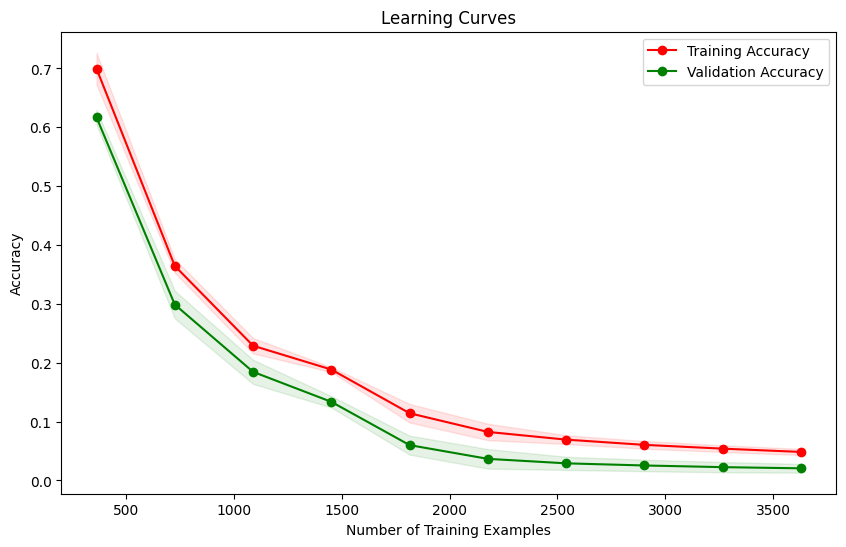

In [6]:
train_sizes, train_scores, val_scores, train_scores_std, val_scores_std = learning_curve(best_classifier,
                                                                                        X_train,
                                                                                        y_train,
                                                                                        n_splits=4,
                                                                                        train_sizes=np.linspace(0.1, 1.0, 10),  # Training set sizes from 10% to 100%
                                                                                        verbose=True
                                                                                        )

# print("Training Scores:", train_scores)
# print("Validation Scores:", val_scores)

# Plotting the learning curves with standard deviations
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes * len(X_train), train_scores - train_scores_std,
                 train_scores + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes * len(X_train), val_scores - val_scores_std,
                 val_scores + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes * len(X_train), train_scores, 'o-', color="r", label='Training Accuracy')
plt.plot(train_sizes * len(X_train), val_scores, 'o-', color="g", label='Validation Accuracy')
plt.xlabel('Number of Training Examples')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()
